#### Objective : We will create a classification model to classify AG News Corpus. The corpus belongs to 4 different classes.
#### Learning Objective : To be able to apply every Sequential Model types to the prject and see performance
    1. RNN using pretrained embddings - We will use Glove 100 D vector for this project
    2. RNN using embedding trained as a part of model training
    3. LSTM using pretrained embedding - We will use Glove 100D vector for this project
    4. LSTM using embedding as a part of model training
    5. GRU using embedding or pretrained embedding, whatever performed better
 
#### We will be using Pytorch for our projects 

#### Data Description - https://www.kaggle.com/amananandrai/ag-news-classification-dataset

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

##### Lets Import the required packages for our project

In [1]:
import pandas as pd #### for any manipulations on the dataframe
import os #### For doing os operations like change directory and all

import spacy ### We will use spacy tokeniser for cleaning our data
import numpy as np ### For any numeric  operations of matrices


#### We will import the torch and will start working on the project
import torch
from torchtext import data ### This provides the pipeline for processing our data
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True ### This will make our experiments reproducible
import torch.nn as nn
import torch.optim as optim ### We will call our optimiser function like adam, sgd etcc....
import torch.nn.functional as F


import random
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import pyprind
%matplotlib inline  

import re ### This will help us in writing regex for cleaning our data


#### Define paths and working directory

In [2]:
#### Change the directory
os.chdir("C:\\Users\\ashwinku\\Desktop\\Pytorch")

### Read the data source placed at the path
path = '\\data\\ag_news_csv\\'

### As we have have GPU avilable we will use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Define the text preprocessing steps

In [3]:
### We will use NLP tokeniser and disable parser and other functionalties for speed
nlp = spacy.load('en_core_web_sm',disable=['parser', 'tagger', 'ner'])

###  Define the tokenizer function to be used later on
def tokenizer(s): 
    return [w.text.lower() for w in nlp(corp_clean(s))]

### Every token should be cleanedbefore going through the process
def corp_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    text = text.replace("\\"," ")
    return text.strip()

### Define the further preprocessing step for each field and created iterator for batch

In [4]:
# By using Data field function from torchtext we candefine how ew ant to process out data

### Definition for processing text field
txt_field = data.Field(sequential=True, ##Whether the datatype represents sequential data
                       tokenize=tokenizer,  use_vocab=True )

### Definition for processing label field
label_field = data.Field(sequential=False, 
                         use_vocab=False, ### Don't use vaocab as it represents label data
                         pad_token=None, 
                         unk_token=None)


### Define which field in csv is label field and which one is text field
train_val_fields = [('label', label_field), # we dont need this, so no processing
    ('text_desc2', txt_field), # process it as label
    ('text_desc', None), # we dont need this, so no processing
                   ]

### We will read the tabular data and craete split from it
train, test = data.TabularDataset.splits(path='C:\\Users\\ashwinku\\Desktop\\Pytorch\\data\\ag_news_csv\\', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='test_2_all.csv', 
                                            fields=train_val_fields, 
                                            skip_header=True)

#### RNN using pretrained Glove embeddings - reuse a learned embedding

In [5]:
#### Now we will load the Glove Embedding and use its weigh in our model

In [6]:
#### Load the vector from Glove txt file, only a few embedding supported at present
from torchtext import vocab
vec = vocab.Vectors('glove.6B.100d.txt',"C:\\Users\\ashwinku\\Desktop\\Pytorch\\glove.6B\\")

### Build the vocabulary using the embeddings
txt_field.build_vocab(train, test, max_size=100000, vectors=vec)
# build vocab for labels
label_field.build_vocab(train)

print(txt_field.vocab.vectors.shape)

### Store the pretrained embedding as vectors
pretrained_embeddings = txt_field.vocab.vectors

### Store the pretrained embedding as model embedding weigh data and make it untrainable
print(pretrained_embeddings.shape)
#### Print look at the frequency of dat
label_field.vocab.freqs


### Create an iterator over Batch of data
traindl, testdl = data.BucketIterator.splits(datasets=(train, test), # specify train and validation Tabulardataset
                                            batch_size = 32,  # batch size of train and validation
                                            sort_key=lambda x: len(x.text_desc2), # on what attribute the text should be sorted
                                            device=device, # -1 mean cpu and 0 or None mean gpu
                                            sort_within_batch=True, 
                                            repeat=False)

torch.Size([37869, 100])
torch.Size([37869, 100])


### Define the training loop - soul moto so we don;t define again and again. Ideally it should be defined after function call

In [7]:
### in training loop model is set to train, and we do backward propogation in time using backprop

def train(model, iterator, optimizer, criterion): 
    epoch_loss2 = 0 ### accumulate loss for every batch
    epoch_acc = 0 ### accumulate accuracy for every batch
    model.train() ### Put the model in training mode 
    bar = pyprind.ProgBar(len(iterator), bar_char='█') ### Just print the 
    for batch in iterator: 
        optimizer.zero_grad() ### for every epoch set gradient to zero otherwise it may start from previous gradients      
        predictions = model(batch.text_desc2).squeeze(0) ### convert from 3d tensor to 2 d tensor
        loss = criterion(predictions, batch.label) #### Calculate the loss
        acc = accuracy_bin(predictions, batch.label) ### Caluclate the accuracy
        epoch_loss2 += loss
        epoch_acc += acc
        loss.backward() ### Do the backward propogation on the loss function
        optimizer.step() ### Update gradients based on loass calculations
        bar.update() ### Update the bar 

    return epoch_loss2 /len(iterator),epoch_acc/len(iterator) ### return batch loss and accuracy

### Define the eval loop, in which model isset to eval mode and gradients are updated
def eval(model, iterator,  criterion): 
    epoch_loss2 = 0
    epoch_acc = 0

    model.eval() ### Puth teh model in eval mode
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        predictions = model(batch.text_desc2).squeeze(0)
        loss = criterion(predictions, batch.label)
        acc = accuracy_bin(predictions, batch.label)
        epoch_loss2 += loss
        epoch_acc += acc
        bar.update()   
    return epoch_loss2 /len(iterator),epoch_acc/len(iterator)


### define plotting helper function
def plotting(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(['train loss','validation loss'])
    plt.xlabel('Number of epochs')
    plt.ylabel('Negative Log Loss')

#### Define the Rnn model module class  - for learning we are using simple rnn with single layer

In [8]:
#### Define the rnn module
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim) ### Input dim and embedding dim
        self.rnn = nn.RNN(embedding_dim, hidden_dim) ### Rnn cells takes embedding dimesnion as input
        self.fc = nn.Linear(hidden_dim, output_dim) ### Fully connected layer
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        out = self.fc(hidden[-1])
#         outputs=self.act(out)
        return out

### define a function which takes logits and actuals lables and predicts accuracy
def accuracy_bin(preds,labels):
    top_n,top_i = preds.topk(1)
    correct = 0
    for i in range(len(labels)):
       if labels[i] ==  top_i[i]:
            correct +=1
    return ((correct/len(labels))*100)

### Define various other parmeters of the model

In [32]:
INPUT_DIM = len(txt_field.vocab) ### Input dimenssion usually equal to length of vocab
EMBEDDING_DIM = 100 ### Embedding dimension we are using 100D glove vectors
HIDDEN_DIM = 400 #### Number of hidden laye
OUTPUT_DIM = 4

### Call the rnn module defines
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
### Set the embedding weights to rpedefines weights of Glove
model.embedding.weight.data = pretrained_embeddings.cuda()
# model.embedding.weight.data = pretrained_embeddings.cpu()
### Use a Stochastic gradient descent with learning rate 0.01 , we could have used momentum also
optimizer = optim.SGD(model.parameters(),  lr=0.01)
### As we are claculating loss on logis we can use cross entrpy which does logsoftmax and negative logloss as backend
criterion = nn.CrossEntropyLoss()
### Load the model and criterion to the device
model = model.to(device)
criterion = criterion.to(device)

### Define the train loop in which we will train model and eval loop to evaluate model

In [34]:
#### Traine the model for 10 epochs atleast

In [35]:
N_EPOCHS = 10
train_loss_list = []
valid_loss_list = []



for epoch in range(N_EPOCHS):

    train_loss,train_acc= train(model, traindl, optimizer, criterion)
    valid_loss, valid_acc = eval(model,  testdl, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print (f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}  | Accuracy Train: {train_acc:.3f} |')
    print (f'| Epoch: {epoch+1:02} | Validation Loss: {valid_loss:.3f}  | Accuracy Validation: {valid_acc:.3f} |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 01 | Train Loss: 0.555  | Accuracy Train: 80.062 |
| Epoch: 01 | Validation Loss: 0.483  | Accuracy Validation: 82.747 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 02 | Train Loss: 0.471  | Accuracy Train: 83.236 |
| Epoch: 02 | Validation Loss: 0.465  | Accuracy Validation: 83.364 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 03 | Train Loss: 0.458  | Accuracy Train: 83.718 |
| Epoch: 03 | Validation Loss: 0.456  | Accuracy Validation: 83.824 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 04 | Train Loss: 0.447  | Accuracy Train: 83.985 |
| Epoch: 04 | Validation Loss: 0.450  | Accuracy Validation: 83.955 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 05 | Train Loss: 0.438  | Accuracy Train: 84.312 |
| Epoch: 05 | Validation Loss: 0.438  | Accuracy Validation: 84.191 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 06 | Train Loss: 0.430  | Accuracy Train: 84.570 |
| Epoch: 06 | Validation Loss: 0.427  | Accuracy Validation: 84.769 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 07 | Train Loss: 0.424  | Accuracy Train: 84.725 |
| Epoch: 07 | Validation Loss: 0.422  | Accuracy Validation: 84.664 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 08 | Train Loss: 0.417  | Accuracy Train: 84.981 |
| Epoch: 08 | Validation Loss: 0.423  | Accuracy Validation: 84.756 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 09 | Train Loss: 0.411  | Accuracy Train: 85.164 |
| Epoch: 09 | Validation Loss: 0.413  | Accuracy Validation: 85.097 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 10 | Train Loss: 0.405  | Accuracy Train: 85.335 |
| Epoch: 10 | Validation Loss: 0.408  | Accuracy Validation: 85.386 |


### We could use 8 epochs as after that validation loss has started increasing - signs of over fitting

Text(0, 0.5, 'Negative Log Loss')

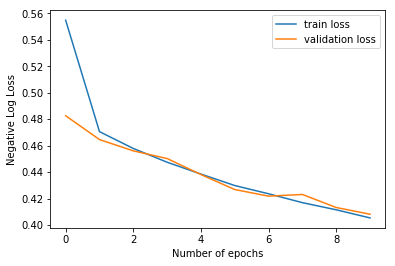

In [36]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(['train loss','validation loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Negative Log Loss')

## RNN model using embedding trained during RNN process itself

In [5]:


### Create dataset using build vocab from torch texxt
### Build the vocabulary using the embeddings
txt_field.build_vocab(train, test, min_freq = 5)
# build vocab for labels
label_field.build_vocab(train)

### Store the pretrained embedding as model embedding weigh data and make it untrainable
#### Print look at the frequency of dat
label_field.vocab.freqs

#### print the length of text field vocab
print (" The number of distinct vocab is :",len(txt_field.vocab.freqs))

#### Checking the indices fo varius words
print ("Indice of word the is :",txt_field.vocab.stoi['reuters'])

### Craete the batch iterator
### Create an iterator over Batch of data
traindl, testdl = data.BucketIterator.splits(datasets=(train, test), # specify train and validation Tabulardataset
                                            batch_size = 32,  # batch size of train and validation
                                            sort_key=lambda x: len(x.text_desc2), # on what attribute the text should be sorted
                                            device=device, # -1 mean cpu and 0 or None mean gpu
                                            sort_within_batch=True, 
                                            repeat=False)

 The number of distinct vocab is : 37867
Indice of word the is : 20


In [6]:

#### EVery iterator will have instance of training data and others with diff lengths
for i, batch in enumerate(traindl):
    print (batch.text_desc2.shape)
    print (batch.label.shape)
    break

torch.Size([7, 32])
torch.Size([32])


In [10]:
### We will use the previous difinition of RNN class just parametres would be diff
INPUT_DIM = len(txt_field.vocab) ### Input dimenssion usually equal to length of vocab
EMBEDDING_DIM = 100 ### Embedding dimension we are using 100D glove vectors
HIDDEN_DIM = 400 #### Number of hidden laye
OUTPUT_DIM = 4

### Call the rnn module defines
model_embed = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

# model.embedding.weight.data = pretrained_embeddings.cpu()
### Use a Stochastic gradient descent with learning rate 0.01 , we could have used momentum also
optimizer = optim.SGD(model_embed.parameters(),  lr=0.01)
### As we are claculating loss on logis we can use cross entrpy which does logsoftmax and negative logloss as backend
criterion = nn.CrossEntropyLoss()
### Load the model and criterion to the device
model_embed = model_embed.to(device)
criterion = criterion.to(device)

In [11]:
N_EPOCHS = 20
train_loss_list = []
valid_loss_list = []



for epoch in range(N_EPOCHS):

    train_loss,train_acc= train(model_embed, traindl, optimizer, criterion)
    valid_loss, valid_acc = eval(model_embed,  testdl, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print (f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}  | Accuracy Train: {train_acc:.3f} |')
    print (f'| Epoch: {epoch+1:02} | Validation Loss: {valid_loss:.3f}  | Accuracy Validation: {valid_acc:.3f} |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 01 | Train Loss: 1.264  | Accuracy Train: 41.172 |
| Epoch: 01 | Validation Loss: 1.202  | Accuracy Validation: 46.376 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 02 | Train Loss: 1.187  | Accuracy Train: 47.932 |
| Epoch: 02 | Validation Loss: 1.162  | Accuracy Validation: 48.595 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 03 | Train Loss: 1.114  | Accuracy Train: 52.678 |
| Epoch: 03 | Validation Loss: 1.027  | Accuracy Validation: 56.946 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 04 | Train Loss: 0.947  | Accuracy Train: 61.894 |
| Epoch: 04 | Validation Loss: 0.879  | Accuracy Validation: 64.601 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 05 | Train Loss: 0.788  | Accuracy Train: 69.531 |
| Epoch: 05 | Validation Loss: 0.792  | Accuracy Validation: 69.144 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 06 | Train Loss: 0.687  | Accuracy Train: 74.151 |
| Epoch: 06 | Validation Loss: 0.710  | Accuracy Validation: 73.044 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 07 | Train Loss: 0.619  | Accuracy Train: 77.014 |
| Epoch: 07 | Validation Loss: 0.719  | Accuracy Validation: 73.280 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 08 | Train Loss: 0.566  | Accuracy Train: 79.215 |
| Epoch: 08 | Validation Loss: 0.697  | Accuracy Validation: 75.118 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 09 | Train Loss: 0.525  | Accuracy Train: 80.813 |
| Epoch: 09 | Validation Loss: 0.594  | Accuracy Validation: 78.348 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 10 | Train Loss: 0.488  | Accuracy Train: 82.202 |
| Epoch: 10 | Validation Loss: 0.596  | Accuracy Validation: 78.440 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 11 | Train Loss: 0.463  | Accuracy Train: 83.218 |
| Epoch: 11 | Validation Loss: 0.579  | Accuracy Validation: 79.740 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 12 | Train Loss: 0.434  | Accuracy Train: 84.271 |
| Epoch: 12 | Validation Loss: 0.587  | Accuracy Validation: 79.123 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 13 | Train Loss: 0.406  | Accuracy Train: 85.342 |
| Epoch: 13 | Validation Loss: 0.593  | Accuracy Validation: 79.596 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 14 | Train Loss: 0.386  | Accuracy Train: 86.061 |
| Epoch: 14 | Validation Loss: 0.576  | Accuracy Validation: 79.753 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 15 | Train Loss: 0.365  | Accuracy Train: 86.892 |
| Epoch: 15 | Validation Loss: 0.701  | Accuracy Validation: 76.917 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 16 | Train Loss: 0.350  | Accuracy Train: 87.424 |
| Epoch: 16 | Validation Loss: 0.583  | Accuracy Validation: 80.016 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 17 | Train Loss: 0.324  | Accuracy Train: 88.278 |
| Epoch: 17 | Validation Loss: 0.613  | Accuracy Validation: 79.399 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 18 | Train Loss: 0.306  | Accuracy Train: 88.895 |
| Epoch: 18 | Validation Loss: 0.632  | Accuracy Validation: 79.582 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 19 | Train Loss: 0.291  | Accuracy Train: 89.480 |
| Epoch: 19 | Validation Loss: 0.628  | Accuracy Validation: 79.451 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 20 | Train Loss: 0.273  | Accuracy Train: 90.109 |
| Epoch: 20 | Validation Loss: 0.642  | Accuracy Validation: 79.517 |


### Looking at validation loss best epoch is at 10 

Text(0, 0.5, 'Negative Log Loss')

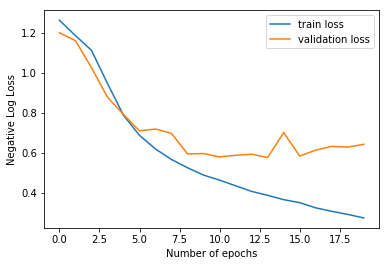

In [12]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(['train loss','validation loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Negative Log Loss')

### We know that pretrained embedding are working better for data

    1. Hypothesis 1: Pre-trained Glove embeddings are trained on news corpus with millions of new article. As these are trained on bigger data maybe its better to use it

### LSTM Trainings : As we have established it works better, we will use pretrained embedding

In [8]:
#### Define the LSTM module
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim) ### Input dim and embedding dim
       
#         self.embedding_dropout = SpatialDropout(0.20) #### 20 % drop out
        self.lstm = nn.LSTM(embedding_dim, hidden_dim) ### Rnn cells takes embedding dimesnion as input
        self.fc = nn.Linear(hidden_dim, output_dim) ### Fully connected layer
        
    def forward(self, x):
        embedded = self.embedding(x)
#         embedded = self.embedding_dropout(embedded)
        output, hidden = self.lstm(embedded)
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        out = self.fc(hidden[-1])
#         outputs=self.act(out)
        return out

### define a function which takes logits and actuals lables and predicts accuracy
def accuracy_bin(preds,labels):
    top_n,top_i = preds.topk(1)
    correct = 0
    for i in range(len(labels)):
       if labels[i] ==  top_i[i]:
            correct +=1
    return ((correct/len(labels))*100)

### Define various parameters of the model

In [9]:
INPUT_DIM = len(txt_field.vocab) ### Input dimenssion usually equal to length of vocab
EMBEDDING_DIM = 100 ### Embedding dimension we are using 100D glove vectors
HIDDEN_DIM = 400 #### Number of hidden laye
OUTPUT_DIM = 4

### Call the rnn module defines
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
### Set the embedding weights to rpedefines weights of Glove
model.embedding.weight.data = pretrained_embeddings.cuda()
# model.embedding.weight.data = pretrained_embeddings.cpu()
### Use a Stochastic gradient descent with learning rate 0.01 , we could have used momentum also
optimizer = optim.SGD(model.parameters(),  lr=0.01)
### As we are claculating loss on logis we can use cross entrpy which does logsoftmax and negative logloss as backend
criterion = nn.CrossEntropyLoss()
### Load the model and criterion to the device
model = model.to(device)
criterion = criterion.to(device)

In [11]:
N_EPOCHS = 18
train_loss_list = []
valid_loss_list = []



for epoch in range(N_EPOCHS):

    train_loss,train_acc= train(model, traindl, optimizer, criterion)
    valid_loss, valid_acc = eval(model,  testdl, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print (f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}  | Accuracy Train: {train_acc:.3f} |')
    print (f'| Epoch: {epoch+1:02} | Validation Loss: {valid_loss:.3f}  | Accuracy Validation: {valid_acc:.3f} |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 01 | Train Loss: 0.669  | Accuracy Train: 76.889 |
| Epoch: 01 | Validation Loss: 0.485  | Accuracy Validation: 82.996 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 02 | Train Loss: 0.478  | Accuracy Train: 83.270 |
| Epoch: 02 | Validation Loss: 0.478  | Accuracy Validation: 83.220 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:36
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


| Epoch: 03 | Train Loss: 0.460  | Accuracy Train: 83.740 |
| Epoch: 03 | Validation Loss: 0.454  | Accuracy Validation: 83.876 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:39
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 04 | Train Loss: 0.448  | Accuracy Train: 84.131 |
| Epoch: 04 | Validation Loss: 0.445  | Accuracy Validation: 84.309 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 05 | Train Loss: 0.438  | Accuracy Train: 84.421 |
| Epoch: 05 | Validation Loss: 0.437  | Accuracy Validation: 84.703 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 06 | Train Loss: 0.429  | Accuracy Train: 84.772 |
| Epoch: 06 | Validation Loss: 0.427  | Accuracy Validation: 85.032 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


| Epoch: 07 | Train Loss: 0.421  | Accuracy Train: 84.897 |
| Epoch: 07 | Validation Loss: 0.423  | Accuracy Validation: 85.176 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 08 | Train Loss: 0.414  | Accuracy Train: 85.237 |
| Epoch: 08 | Validation Loss: 0.413  | Accuracy Validation: 85.334 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 09 | Train Loss: 0.408  | Accuracy Train: 85.403 |
| Epoch: 09 | Validation Loss: 0.407  | Accuracy Validation: 85.662 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:37
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 10 | Train Loss: 0.402  | Accuracy Train: 85.605 |
| Epoch: 10 | Validation Loss: 0.401  | Accuracy Validation: 86.082 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 11 | Train Loss: 0.396  | Accuracy Train: 85.823 |
| Epoch: 11 | Validation Loss: 0.398  | Accuracy Validation: 86.187 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 12 | Train Loss: 0.391  | Accuracy Train: 85.994 |
| Epoch: 12 | Validation Loss: 0.393  | Accuracy Validation: 86.239 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 13 | Train Loss: 0.387  | Accuracy Train: 86.132 |
| Epoch: 13 | Validation Loss: 0.388  | Accuracy Validation: 86.292 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 14 | Train Loss: 0.382  | Accuracy Train: 86.342 |
| Epoch: 14 | Validation Loss: 0.396  | Accuracy Validation: 85.872 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 15 | Train Loss: 0.378  | Accuracy Train: 86.417 |
| Epoch: 15 | Validation Loss: 0.384  | Accuracy Validation: 86.555 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 16 | Train Loss: 0.373  | Accuracy Train: 86.615 |
| Epoch: 16 | Validation Loss: 0.378  | Accuracy Validation: 86.752 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 17 | Train Loss: 0.370  | Accuracy Train: 86.733 |
| Epoch: 17 | Validation Loss: 0.376  | Accuracy Validation: 86.725 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 18 | Train Loss: 0.366  | Accuracy Train: 86.873 |
| Epoch: 18 | Validation Loss: 0.375  | Accuracy Validation: 86.778 |


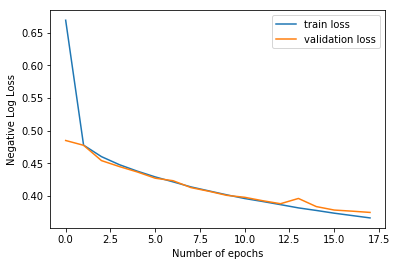

In [15]:
plotting(train_loss_list,valid_loss_list)

### LSTM is performing better than RNN by around 2%

#### LSTM with dropout at input embeding layer

In [8]:
#### Define the LSTM module
class LSTM_dropout(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim,dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim) ### Input dim and embedding dim
        self.dropout = nn.Dropout(dropout)
#         self.embedding_dropout = SpatialDropout(0.20) #### 20 % drop out
        self.lstm = nn.LSTM(embedding_dim, hidden_dim) ### Rnn cells takes embedding dimesnion as input
        self.fc = nn.Linear(hidden_dim, output_dim) ### Fully connected layer
        
    def forward(self, x):
        embedded = self.embedding(x)
#         embedded = self.embedding_dropout(embedded)
        embed = self.dropout(embedded)
        output, hidden = self.lstm(embed)
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        out = self.fc(hidden[-1])
#         outputs=self.act(out)
        return out

### define a function which takes logits and actuals lables and predicts accuracy
def accuracy_bin(preds,labels):
    top_n,top_i = preds.topk(1)
    correct = 0
    for i in range(len(labels)):
       if labels[i] ==  top_i[i]:
            correct +=1
    return ((correct/len(labels))*100)

### Define various parameters for the models

In [9]:
INPUT_DIM = len(txt_field.vocab) ### Input dimenssion usually equal to length of vocab
EMBEDDING_DIM = 100 ### Embedding dimension we are using 100D glove vectors
HIDDEN_DIM = 400 #### Number of hidden laye
OUTPUT_DIM = 4
DROPOUT = 0.2
### Call the rnn module defines
model = LSTM_dropout(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,DROPOUT)
### Set the embedding weights to rpedefines weights of Glove
model.embedding.weight.data = pretrained_embeddings.cuda()
# model.embedding.weight.data = pretrained_embeddings.cpu()
### Use a Stochastic gradient descent with learning rate 0.01 , we could have used momentum also
optimizer = optim.SGD(model.parameters(),  lr=0.01)
### As we are claculating loss on logis we can use cross entrpy which does logsoftmax and negative logloss as backend
criterion = nn.CrossEntropyLoss()
### Load the model and criterion to the device
model = model.to(device)
criterion = criterion.to(device)

In [10]:
N_EPOCHS = 40
train_loss_list = []
valid_loss_list = []



for epoch in range(N_EPOCHS):

    train_loss,train_acc= train(model, traindl, optimizer, criterion)
    valid_loss, valid_acc = eval(model,  testdl, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print (f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}  | Accuracy Train: {train_acc:.3f} |')
    print (f'| Epoch: {epoch+1:02} | Validation Loss: {valid_loss:.3f}  | Accuracy Validation: {valid_acc:.3f} |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 01 | Train Loss: 0.702  | Accuracy Train: 75.118 |
| Epoch: 01 | Validation Loss: 0.491  | Accuracy Validation: 83.220 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 02 | Train Loss: 0.515  | Accuracy Train: 81.702 |
| Epoch: 02 | Validation Loss: 0.467  | Accuracy Validation: 83.259 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 03 | Train Loss: 0.494  | Accuracy Train: 82.443 |
| Epoch: 03 | Validation Loss: 0.451  | Accuracy Validation: 84.244 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 04 | Train Loss: 0.480  | Accuracy Train: 82.870 |
| Epoch: 04 | Validation Loss: 0.462  | Accuracy Validation: 83.469 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 05 | Train Loss: 0.470  | Accuracy Train: 83.177 |
| Epoch: 05 | Validation Loss: 0.435  | Accuracy Validation: 84.638 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 06 | Train Loss: 0.460  | Accuracy Train: 83.557 |
| Epoch: 06 | Validation Loss: 0.430  | Accuracy Validation: 84.690 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 07 | Train Loss: 0.450  | Accuracy Train: 83.929 |
| Epoch: 07 | Validation Loss: 0.417  | Accuracy Validation: 85.176 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 08 | Train Loss: 0.443  | Accuracy Train: 84.080 |
| Epoch: 08 | Validation Loss: 0.414  | Accuracy Validation: 85.360 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 09 | Train Loss: 0.436  | Accuracy Train: 84.408 |
| Epoch: 09 | Validation Loss: 0.404  | Accuracy Validation: 85.872 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 10 | Train Loss: 0.432  | Accuracy Train: 84.422 |
| Epoch: 10 | Validation Loss: 0.402  | Accuracy Validation: 85.846 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 11 | Train Loss: 0.425  | Accuracy Train: 84.674 |
| Epoch: 11 | Validation Loss: 0.407  | Accuracy Validation: 85.793 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 12 | Train Loss: 0.421  | Accuracy Train: 84.838 |
| Epoch: 12 | Validation Loss: 0.406  | Accuracy Validation: 85.517 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 13 | Train Loss: 0.416  | Accuracy Train: 85.054 |
| Epoch: 13 | Validation Loss: 0.387  | Accuracy Validation: 86.305 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 14 | Train Loss: 0.412  | Accuracy Train: 85.109 |
| Epoch: 14 | Validation Loss: 0.388  | Accuracy Validation: 86.279 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 15 | Train Loss: 0.408  | Accuracy Train: 85.326 |
| Epoch: 15 | Validation Loss: 0.385  | Accuracy Validation: 86.384 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 16 | Train Loss: 0.404  | Accuracy Train: 85.423 |
| Epoch: 16 | Validation Loss: 0.381  | Accuracy Validation: 86.673 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 17 | Train Loss: 0.400  | Accuracy Train: 85.531 |
| Epoch: 17 | Validation Loss: 0.377  | Accuracy Validation: 86.830 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 18 | Train Loss: 0.396  | Accuracy Train: 85.743 |
| Epoch: 18 | Validation Loss: 0.373  | Accuracy Validation: 86.909 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 19 | Train Loss: 0.394  | Accuracy Train: 85.832 |
| Epoch: 19 | Validation Loss: 0.371  | Accuracy Validation: 86.949 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 20 | Train Loss: 0.390  | Accuracy Train: 85.936 |
| Epoch: 20 | Validation Loss: 0.372  | Accuracy Validation: 86.962 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 21 | Train Loss: 0.388  | Accuracy Train: 86.059 |
| Epoch: 21 | Validation Loss: 0.369  | Accuracy Validation: 86.922 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 22 | Train Loss: 0.386  | Accuracy Train: 85.993 |
| Epoch: 22 | Validation Loss: 0.368  | Accuracy Validation: 87.040 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 23 | Train Loss: 0.384  | Accuracy Train: 86.149 |
| Epoch: 23 | Validation Loss: 0.368  | Accuracy Validation: 87.080 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:30
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 24 | Train Loss: 0.380  | Accuracy Train: 86.326 |
| Epoch: 24 | Validation Loss: 0.364  | Accuracy Validation: 87.224 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 25 | Train Loss: 0.378  | Accuracy Train: 86.418 |
| Epoch: 25 | Validation Loss: 0.367  | Accuracy Validation: 86.949 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 26 | Train Loss: 0.376  | Accuracy Train: 86.414 |
| Epoch: 26 | Validation Loss: 0.380  | Accuracy Validation: 86.752 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 27 | Train Loss: 0.374  | Accuracy Train: 86.453 |
| Epoch: 27 | Validation Loss: 0.357  | Accuracy Validation: 87.447 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 28 | Train Loss: 0.371  | Accuracy Train: 86.601 |
| Epoch: 28 | Validation Loss: 0.357  | Accuracy Validation: 87.342 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 29 | Train Loss: 0.370  | Accuracy Train: 86.697 |
| Epoch: 29 | Validation Loss: 0.365  | Accuracy Validation: 87.264 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 30 | Train Loss: 0.368  | Accuracy Train: 86.734 |
| Epoch: 30 | Validation Loss: 0.353  | Accuracy Validation: 87.618 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 31 | Train Loss: 0.366  | Accuracy Train: 86.756 |
| Epoch: 31 | Validation Loss: 0.356  | Accuracy Validation: 87.264 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 32 | Train Loss: 0.362  | Accuracy Train: 86.923 |
| Epoch: 32 | Validation Loss: 0.358  | Accuracy Validation: 87.172 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


| Epoch: 33 | Train Loss: 0.361  | Accuracy Train: 86.944 |
| Epoch: 33 | Validation Loss: 0.353  | Accuracy Validation: 87.789 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 34 | Train Loss: 0.359  | Accuracy Train: 86.978 |
| Epoch: 34 | Validation Loss: 0.348  | Accuracy Validation: 87.815 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 35 | Train Loss: 0.358  | Accuracy Train: 87.070 |
| Epoch: 35 | Validation Loss: 0.349  | Accuracy Validation: 87.855 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 36 | Train Loss: 0.357  | Accuracy Train: 87.086 |
| Epoch: 36 | Validation Loss: 0.350  | Accuracy Validation: 87.553 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 37 | Train Loss: 0.355  | Accuracy Train: 87.215 |
| Epoch: 37 | Validation Loss: 0.348  | Accuracy Validation: 87.631 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:33
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 38 | Train Loss: 0.352  | Accuracy Train: 87.234 |
| Epoch: 38 | Validation Loss: 0.345  | Accuracy Validation: 87.946 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 39 | Train Loss: 0.351  | Accuracy Train: 87.338 |
| Epoch: 39 | Validation Loss: 0.342  | Accuracy Validation: 87.894 |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


| Epoch: 40 | Train Loss: 0.350  | Accuracy Train: 87.407 |
| Epoch: 40 | Validation Loss: 0.342  | Accuracy Validation: 87.960 |


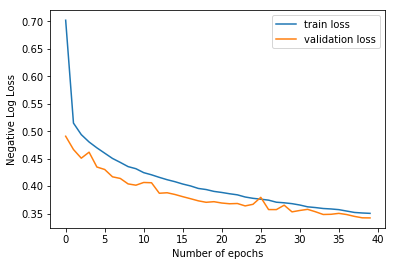

In [11]:

plotting(train_loss_list,valid_loss_list)